In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For confusion matrix plotting
import librosa
import librosa.display
import joblib
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical # For one-hot encoding true labels
import warnings
warnings.filterwarnings('ignore')

# --- PATHS ---
# Path to the Common Voice dataset (added as input to this notebook)
COMMON_VOICE_DATASET_ROOT = "/kaggle/input/common-voice/"

# Path to YOUR UPLOADED MODEL ARTIFACTS DATASET
# This is derived from your dataset URL: www.kaggle.com/datasets/kkhushibe22/cv-age-prediction-model
YOUR_MODEL_DATASET_SLUG = "cv-age-prediction-model"
MODEL_ARTIFACTS_PATH = f"/kaggle/input/{YOUR_MODEL_DATASET_SLUG}/"

# Paths for metadata CSVs from Common Voice dataset
COMMON_VOICE_METADATA_TEST_CSV = os.path.join(COMMON_VOICE_DATASET_ROOT, "cv-valid-test.csv")

# Path to the ACTUAL AUDIO FILES DIRECTORY for the test set
ACTUAL_AUDIO_TEST_CLIPS_PATH = os.path.join(COMMON_VOICE_DATASET_ROOT, "cv-valid-test", "cv-valid-test")

# --- Verification ---
print(f"Path to your uploaded model artifacts: {MODEL_ARTIFACTS_PATH}")
print(f"  - Exists: {os.path.exists(MODEL_ARTIFACTS_PATH)}")
if os.path.exists(MODEL_ARTIFACTS_PATH):
    print(f"  - Contents: {os.listdir(MODEL_ARTIFACTS_PATH)}") # Should list your .h5 and .pkl files

print(f"Test Metadata CSV: {COMMON_VOICE_METADATA_TEST_CSV} - Exists: {os.path.exists(COMMON_VOICE_METADATA_TEST_CSV)}")
print(f"Actual Test Audio Clips Path: {ACTUAL_AUDIO_TEST_CLIPS_PATH} - Exists: {os.path.exists(ACTUAL_AUDIO_TEST_CLIPS_PATH)}")

2025-05-19 08:18:58.388350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747642738.620890      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747642738.688053      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Path to your uploaded model artifacts: /kaggle/input/cv-age-prediction-model/
  - Exists: True
  - Contents: ['best_age_model_cnn.h5', 'dl_age_label_encoder.pkl']
Test Metadata CSV: /kaggle/input/common-voice/cv-valid-test.csv - Exists: True
Actual Test Audio Clips Path: /kaggle/input/common-voice/cv-valid-test/cv-valid-test - Exists: True


In [2]:
# Parameters for spectrogram (should match those used during training)
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
MAX_FRAMES = 256 # Max frames to ensure fixed size input

def audio_to_melspectrogram(filepath, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, max_frames=MAX_FRAMES):
    try:
        audio, _ = librosa.load(filepath, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        if log_mel_spec.shape[1] < max_frames:
            pad_width = max_frames - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
        else:
            log_mel_spec = log_mel_spec[:, :max_frames]
        return log_mel_spec
    except Exception as e:
        print(f"Error generating spectrogram for {filepath}: {e}")
        return None

print("Spectrogram parameters and function defined.")

Spectrogram parameters and function defined.


In [3]:
def load_and_prepare_test_metadata(csv_path, base_audio_path_root, age_label_encoder):
    try:
        df_meta = pd.read_csv(csv_path)
        print(f"Loaded {os.path.basename(csv_path)} with shape: {df_meta.shape}")
    except FileNotFoundError:
        print(f"ERROR: CSV file not found at {csv_path}.")
        return pd.DataFrame()

    df_meta_cleaned = df_meta[['filename', 'age', 'gender']].copy()
    df_meta_cleaned.dropna(subset=['age', 'gender'], inplace=True)

    # Construct full audio path
    def construct_actual_path(csv_filename_entry):
        parts = csv_filename_entry.split('/')
        if len(parts) == 2: # e.g., 'cv-valid-test/sample-xxxxx.mp3'
            # This path needs to point to where the audio files actually are
            # COMMON_VOICE_DATASET_ROOT / cv-valid-test / cv-valid-test / sample-xxxxx.mp3
            return os.path.join(COMMON_VOICE_DATASET_ROOT, parts[0], parts[0], parts[1])
        return os.path.join(COMMON_VOICE_DATASET_ROOT, csv_filename_entry) # Fallback

    df_meta_cleaned['full_audio_path'] = df_meta_cleaned['filename'].apply(construct_actual_path)

    # Validate file existence
    original_count = len(df_meta_cleaned)
    df_meta_cleaned = df_meta_cleaned[df_meta_cleaned['full_audio_path'].apply(os.path.exists)].copy()
    print(f"Path validation: {len(df_meta_cleaned)} audio files found out of {original_count} entries.")

    # Encode 'age' for true labels using the loaded encoder
    # Handle unseen labels by marking them for removal
    if age_label_encoder:
        df_meta_cleaned['age_encoded_true'] = df_meta_cleaned['age'].apply(
            lambda x: age_label_encoder.transform([x])[0] if x in age_label_encoder.classes_ else -1
        )
        # Filter out rows with ages not present in the training set (and thus encoder)
        df_meta_cleaned = df_meta_cleaned[df_meta_cleaned['age_encoded_true'] != -1].copy()
        print(f"Shape after age encoding and filtering unknown age labels: {df_meta_cleaned.shape}")
    else:
        print("Age label encoder not provided; 'age_encoded_true' column will not be created.")
        df_meta_cleaned['age_encoded_true'] = -1 # Placeholder

    return df_meta_cleaned[['filename', 'age', 'full_audio_path', 'age_encoded_true']].reset_index(drop=True)

# Load Age Label Encoder (needed before loading test metadata for proper encoding of true labels)
# MODEL_ARTIFACTS_PATH is defined in Cell 1
age_encoder_path_pkl = os.path.join(MODEL_ARTIFACTS_PATH, 'dl_age_label_encoder.pkl') # Filename from your image
loaded_age_label_encoder_dl = None
if os.path.exists(age_encoder_path_pkl):
    loaded_age_label_encoder_dl = joblib.load(age_encoder_path_pkl)
    print(f"Loaded age label encoder from: {age_encoder_path_pkl}")
    print(f"Age classes from encoder: {loaded_age_label_encoder_dl.classes_}")
else:
    print(f"ERROR: Age label encoder file not found at {age_encoder_path_pkl}. Cannot proceed with evaluation.")
    print(f"Please ensure the file 'dl_age_label_encoder.pkl' is present in your dataset: {MODEL_ARTIFACTS_PATH}")


# Load test data and prepare it
if loaded_age_label_encoder_dl:
    df_test_eval = load_and_prepare_test_metadata(COMMON_VOICE_METADATA_TEST_CSV,
                                                  ACTUAL_AUDIO_TEST_CLIPS_PATH,
                                                  loaded_age_label_encoder_dl)
    if not df_test_eval.empty:
        print("\nTest Data for Evaluation (Head):")
        print(df_test_eval.head())
    else:
        print("df_test_eval is empty after processing.")
else:
    df_test_eval = pd.DataFrame() # Ensure it's defined even if encoder fails
    print("Skipping test data loading due to missing age encoder.")

Loaded age label encoder from: /kaggle/input/cv-age-prediction-model/dl_age_label_encoder.pkl
Age classes from encoder: ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']
Loaded cv-valid-test.csv with shape: (3995, 8)
Path validation: 1535 audio files found out of 1535 entries.
Shape after age encoding and filtering unknown age labels: (1535, 5)

Test Data for Evaluation (Head):
                          filename       age  \
0  cv-valid-test/sample-000001.mp3  twenties   
1  cv-valid-test/sample-000003.mp3  twenties   
2  cv-valid-test/sample-000005.mp3  twenties   
3  cv-valid-test/sample-000006.mp3  twenties   
4  cv-valid-test/sample-000007.mp3  thirties   

                                     full_audio_path  age_encoded_true  
0  /kaggle/input/common-voice/cv-valid-test/cv-va...                 7  
1  /kaggle/input/common-voice/cv-valid-test/cv-va...                 7  
2  /kaggle/input/common-voice/cv-valid-test/cv-va...                 7  
3

In [4]:
# MODEL_ARTIFACTS_PATH is defined in Cell 1
age_model_path_h5 = os.path.join(MODEL_ARTIFACTS_PATH, "best_age_model_cnn.h5") # Filename from your image

loaded_age_model_cnn = None
age_model_loaded_for_pred = False

try:
    if os.path.exists(age_model_path_h5):
        loaded_age_model_cnn = tf.keras.models.load_model(age_model_path_h5)
        print(f"Loaded age model from: {age_model_path_h5}")
        # loaded_age_model_cnn.summary() # Optional: display model summary
        age_model_loaded_for_pred = True
    else:
        print(f"Age model file not found at: {age_model_path_h5}")
        print(f"Please ensure the file 'best_age_model_cnn.h5' is present in your dataset: {MODEL_ARTIFACTS_PATH}")


    if not loaded_age_label_encoder_dl: # Check from previous cell
        print("Age label encoder was not loaded. Age prediction will not work correctly.")
        age_model_loaded_for_pred = False # Ensure this is false if encoder is missing

    if age_model_loaded_for_pred:
        print("\nAge model and encoder are ready for prediction.")
    else:
        print("\nAge model or encoder failed to load. Predictions cannot be made.")

except Exception as e:
    print(f"Error loading age model: {e}")
    age_model_loaded_for_pred = False

I0000 00:00:1747642756.613580      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747642756.614269      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loaded age model from: /kaggle/input/cv-age-prediction-model/best_age_model_cnn.h5

Age model and encoder are ready for prediction.


In [5]:
y_true_age_indices = []
y_pred_age_indices = []
y_pred_age_labels_examples = [] # For viewing some predictions
true_age_labels_examples = []

if age_model_loaded_for_pred and not df_test_eval.empty:
    print(f"\nStarting predictions on {len(df_test_eval)} test samples...")
    # Limiting to a subset for quicker testing, remove '[:50]' for full test set
    # For full evaluation, you might want to process all, but it can be time-consuming
    df_to_predict = df_test_eval 
    #df_to_predict = df_test_eval.sample(n=min(100, len(df_test_eval)), random_state=42) # Predict on a sample of 100 or less
    print(f"Predicting on a sample of {len(df_to_predict)} files for demonstration.")

    for index, row in df_to_predict.iterrows():
        audio_filepath = row['full_audio_path']
        true_age_encoded = row['age_encoded_true'] # This is the numeric encoded label
        true_age_str = row['age'] # This is the string label ('teens', 'twenties', etc.)

        mel_spec = audio_to_melspectrogram(audio_filepath)
        if mel_spec is None:
            print(f"Skipping {audio_filepath} due to spectrogram error.")
            continue

        spectrogram_reshaped = np.expand_dims(mel_spec, axis=0)
        spectrogram_reshaped = np.expand_dims(spectrogram_reshaped, axis=-1)

        try:
            age_probs = loaded_age_model_cnn.predict(spectrogram_reshaped, verbose=0)
            predicted_age_idx = np.argmax(age_probs)

            y_true_age_indices.append(int(true_age_encoded)) # Ensure it's int for metrics
            y_pred_age_indices.append(predicted_age_idx)
            
            if len(y_pred_age_labels_examples) < 10: # Print a few examples
                 predicted_age_label_str = loaded_age_label_encoder_dl.inverse_transform([predicted_age_idx])[0]
                 y_pred_age_labels_examples.append(predicted_age_label_str)
                 true_age_labels_examples.append(true_age_str)
                 # print(f"File: {os.path.basename(audio_filepath)}, True: {true_age_str} (Enc:{true_age_encoded}), Pred: {predicted_age_label_str} (Idx:{predicted_age_idx})")

        except Exception as e:
            print(f"Error predicting for {audio_filepath}: {e}")
    
    print("\nExample Predictions (True vs. Predicted):")
    for true_label, pred_label in zip(true_age_labels_examples, y_pred_age_labels_examples):
        print(f"True: {true_label:<10} | Predicted: {pred_label}")
    print("\nPredictions completed on the sample.")

else:
    if not age_model_loaded_for_pred:
        print("Age model/encoder not loaded. Cannot perform batch predictions.")
    if df_test_eval.empty:
        print("df_test_eval is empty. Cannot perform batch predictions.")


Starting predictions on 1535 test samples...
Predicting on a sample of 1535 files for demonstration.


I0000 00:00:1747642772.200265      60 service.cc:148] XLA service 0x7c38e8002490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747642772.201168      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747642772.201192      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747642772.330288      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747642773.907282      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Example Predictions (True vs. Predicted):
True: twenties   | Predicted: twenties
True: twenties   | Predicted: twenties
True: twenties   | Predicted: twenties
True: twenties   | Predicted: fifties
True: thirties   | Predicted: thirties
True: thirties   | Predicted: fourties
True: fifties    | Predicted: twenties
True: twenties   | Predicted: twenties
True: twenties   | Predicted: twenties
True: twenties   | Predicted: fifties

Predictions completed on the sample.



--- Age Model Evaluation Metrics (on the sampled test data) ---
Overall Accuracy: 0.7049

Classification Report:
              precision    recall  f1-score   support

    eighties       0.33      0.20      0.25         5
     fifties       0.73      0.76      0.75       205
    fourties       0.77      0.62      0.69       233
   seventies       0.83      0.81      0.82        36
     sixties       0.75      0.75      0.75        88
       teens       0.72      0.47      0.57       117
    thirties       0.64      0.77      0.70       388
    twenties       0.71      0.72      0.71       463

    accuracy                           0.70      1535
   macro avg       0.69      0.64      0.65      1535
weighted avg       0.71      0.70      0.70      1535



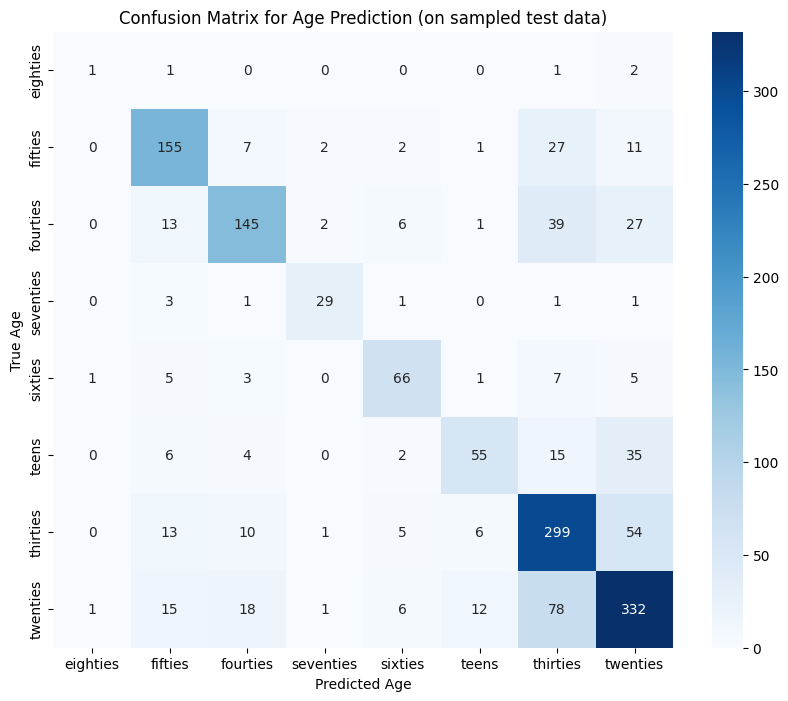

In [6]:
if age_model_loaded_for_pred and y_true_age_indices and y_pred_age_indices:
    print("\n--- Age Model Evaluation Metrics (on the sampled test data) ---")

    # Overall Accuracy
    accuracy = accuracy_score(y_true_age_indices, y_pred_age_indices)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Classification Report
    # Ensure target_names match the order in loaded_age_label_encoder_dl.classes_
    age_class_names = loaded_age_label_encoder_dl.classes_
    
    # Get unique labels present in y_true_age_indices and y_pred_age_indices
    # to avoid "Target is multiclass but average='binary'" if some classes are missing in the sample
    unique_labels_in_test = np.unique(y_true_age_indices + y_pred_age_indices)
    
    # Filter target_names if necessary, or ensure all classes are represented for a full report
    # For simplicity here, we'll use all class names, but be mindful if your sample is small.
    
    try:
        report = classification_report(y_true_age_indices, y_pred_age_indices, 
                                       labels=np.arange(len(age_class_names)), # use indices from 0 to num_classes-1
                                       target_names=age_class_names, 
                                       zero_division=0)
        print("\nClassification Report:")
        print(report)
    except ValueError as ve:
        print(f"\nCould not generate full classification report: {ve}")
        print("This might happen if not all classes are present in the sampled predictions.")
        print("Showing report for available labels:")
        report_subset = classification_report(y_true_age_indices, y_pred_age_indices, 
                                              labels=unique_labels_in_test,
                                              target_names=[age_class_names[i] for i in unique_labels_in_test],
                                              zero_division=0)
        print(report_subset)


    # Confusion Matrix
    cm = confusion_matrix(y_true_age_indices, y_pred_age_indices, labels=np.arange(len(age_class_names)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=age_class_names, 
                yticklabels=age_class_names)
    plt.xlabel('Predicted Age')
    plt.ylabel('True Age')
    plt.title('Confusion Matrix for Age Prediction (on sampled test data)')
    plt.show()
else:
    print("Not enough data or model not loaded for evaluation.")